In [1]:
import copy as cp
import random
import string

def metafunction(n, a, o):
    """
    n is the number of operations returned
    a is the number of agents
    o is the number of unique objects: each agent receives a quantity of objects at the beginning
    """
    assert n > 0 and isinstance(n, int)
    alphabet = string.ascii_lowercase
    agents = alphabet[:a]
    
    ops = ['@1-2-give-q@', '@1-buy-q@', '@1-lose-q@']
    agents = {ag:{i:random.randint(0, 10) for i in range(o)} for ag in agents}
    
    prompt = f"There are {a} agents, {[ag for ag in agents]}. Each of them has {o} items, {[f'obj-{ob}' for ob in range(o)]}.\n"
    prompt += "Here is the initial quantity of each object per agent.\n\n"
    for ag in agents:
        prompt += f"Agent-{ag} has "
        for ob in range(o):
            prompt += f"{agents[ag][ob]} obj-{ob}, "
        prompt = prompt[:-2] + ".\n"
    prompt += "\nHere's the list of potential interactions between agents.\n"
    prompt += f"An agent can give a quantity of one their objects to another agent. In that case, they lose that quantity of that object and the other agent increases theirs'.\n"  # Trade
    prompt += f"An agent can lose some or all of their objects. In that case, they lose that quantity of that object.\n"  # Lose
    prompt += f"An agent can buy some quantity of an object. In that case, they increase the quantity of that object.\n"  # Buy
    prompt += "Here's a list of real interactions between the agents. At the end of the interactions, I will ask you to tell me the exact quantity of an object a specific agent has.\n\n"
    
    program = ''
    for ag in agents:
        program += '; '.join([f'{ag}{i}={agents[ag][i]}' for i in range(o)]) + '\n'
    
    max_tradable = 5
    for _ in range(n):
        v1 = random.choice(list(agents.keys()))  # first agent
        # print(f"A1: {v1}")
        op = random.choice(ops)  # operation
        if all([ai>0 for ai in agents[v1].values()]):  # must have something to give or lose, otherwise use buy
            if op == '@1-2-give-q@':  # agent1 gives to agent2 quantity q of an object they have
                # print("Trade")
                set_agents = set(agents).difference(v1)
                v2 = random.choice(list(set_agents))  # chose another agent
                givable = [i for i in range(o) if agents[v1][i]>0] #  select an object v1 can give
                to_give = random.choice(givable)
                qt = random.randint(1, agents[v1][to_give])
                if qt == agents[v1][to_give]:
                    program += f"{v2}{to_give} += {v1}{to_give}\n{v1}{to_give} -= {v1}{to_give}\n"
                    agents[v1][to_give] -= qt
                    agents[v2][to_give] += qt
                    assert agents[v1][to_give] >= 0
                    prompt += f"Agent-{v1} gives all their obj-{to_give} to agent-{v2}.\n"
                else: 
                    program += f"{v2}{to_give} += {qt}\n{v1}{to_give} -= {qt}\n"
                    agents[v1][to_give] -= qt
                    agents[v2][to_give] += qt
                    prompt += f"Agent-{v1} gives {qt} obj-{to_give} to agent-{v2}.\n"
                    assert agents[v1][to_give] >= 0
            elif op == '@1-buy-q@':  # agent1 buys things
                # print("Buy")
                ob = random.randint(0, o-1)
                qt = random.randint(1, max_tradable)
                program += f"{v1}{ob} += {qt}\n"
                agents[v1][ob] += qt
                prompt += f"Agent-{v1} buys {qt} obj-{ob}.\n"
            else: # agent1 loses a quantity q of an object they have
                # print("Lose")
                # print("all", agents[v1])
                givable = [i for i in range(o) if agents[v1][i]>0] #  select an object v1 can give
                # print("givable", givable)
                to_give = random.choice(givable)
                qt = random.randint(1, agents[v1][to_give])
                # print("togive", to_give)
                # print("qt", qt)
                if qt == agents[v1][to_give]:
                    program += f"{v1}{to_give} -= {v1}{to_give}\n" 
                    agents[v1][to_give] -= qt  
                    prompt += f"Agent-{v1} loses all their obj-{to_give}.\n"
                    assert agents[v1][to_give] >= 0
                else:
                    program += f"{v1}{to_give} -= {qt}\n"   
                    agents[v1][to_give] -= qt
                    prompt += f"Agent-{v1} loses {qt} obj-{to_give}.\n" 
                    assert agents[v1][to_give] >= 0   
        else:  # only option is for agent1 to buy things
            # print("Buy-1")
            ob = random.randint(0, o-1)
            qt = random.randint(1, max_tradable)
            program += f"{v1}{ob} += {qt}\n"
            agents[v1][ob] += qt
            prompt += f"Agent-{v1} buys {qt} obj-{ob}.\n"
        # print(program)
    
    return program, prompt


In [2]:
# Create the programs
program, prompt = metafunction(10, 3, 2)
print(program)
print(prompt)

a0=9; a1=7
b0=10; b1=3
c0=2; c1=2
a1 += b1
b1 -= b1
b1 += 4
b1 -= 3
a1 += 5
b1 += 1
c1 += 3
a0 -= 8
c0 += 3
b1 += 4
a1 -= 4
c1 += 1
a1 -= 1

There are 3 agents, ['a', 'b', 'c']. Each of them has 2 items, ['obj-0', 'obj-1'].
Here is the initial quantity of each object per agent.

Agent-a has 9 obj-0, 7 obj-1.
Agent-b has 10 obj-0, 3 obj-1.
Agent-c has 2 obj-0, 2 obj-1.

Here's the list of potential interactions between agents.
An agent can give a quantity of one their objects to another agent. In that case, they lose that quantity of that object and the other agent increases theirs'.
An agent can lose some or all of their objects. In that case, they lose that quantity of that object.
An agent can buy some quantity of an object. In that case, they increase the quantity of that object.
Here's a list of real interactions between the agents. At the end of the interactions, I will ask you to tell me the exact quantity of an object a specific agent has.

Agent-b gives all their obj-1 to agent

In [3]:
def pretty_prompt(prompt, agent_names, object_names):
    """
    For now we assume agents are in the format agent-l where 
    l are characters in the alphabet, objects are in the format obj-j,
    where j is an integer from 0 to n-1 (included).
    """
    alphabet = string.ascii_lowercase
    for a,c in zip(agent_names, alphabet):
        prompt = prompt.replace(f"Agent-{c}", a).replace(f"agent-{c}", a)
        prompt = prompt.replace(f"'{c}'", f"'{a}'")
    for i,o in enumerate(object_names):
        prompt = prompt.replace(f"Obj-{i}", o).replace(f"obj-{i}", o)
    return prompt

x = pretty_prompt(prompt, ['Alice', 'Bob', 'Tom'], ['Apples', 'Pears'])
print(x)
    

There are 3 agents, ['Alice', 'Bob', 'Tom']. Each of them has 2 items, ['Apples', 'Pears'].
Here is the initial quantity of each object per agent.

Alice has 9 Apples, 7 Pears.
Bob has 10 Apples, 3 Pears.
Tom has 2 Apples, 2 Pears.

Here's the list of potential interactions between agents.
An agent can give a quantity of one their objects to another agent. In that case, they lose that quantity of that object and the other agent increases theirs'.
An agent can lose some or all of their objects. In that case, they lose that quantity of that object.
An agent can buy some quantity of an object. In that case, they increase the quantity of that object.
Here's a list of real interactions between the agents. At the end of the interactions, I will ask you to tell me the exact quantity of an object a specific agent has.

Bob gives all their Pears to Alice.
Bob buys 4 Pears.
Bob loses 3 Pears.
Alice buys 5 Pears.
Bob buys 1 Pears.
Tom buys 3 Pears.
Alice loses 8 Apples.
Tom buys 3 Apples.
Alice g

In [4]:
import random 
# Create some programs
n_programs = 30
# min_n, max_n = 50, 100  # number of operations per program
# min_v, max_v = 5, 10  # number of variables per program

alphabet = string.ascii_lowercase
agent_names = ['Alice', 'Bob', 'Tom', 'Sarah', 'Matthew', 'Donna']
object_names = ['Apples', 'Pears', 'Euros', 'Dollars', \
                'Books', 'Bottles', 'Shoes', 'Shirts']

n = 50  # 10, 20, 30, 40, 50 
a = 3  # number of agents
o = 2  # number of objects
programs = {}
for i in range(n_programs):
    programs[i] = {}
    programs[i]['ops'] = n
    programs[i]['n_agents'] = a
    programs[i]['n_objects'] = o
    programs[i]['n_vars'] = a*o
    programs[i]['code'], programs[i]['prompt'] = metafunction(n, a, o)
    
    random.shuffle(agent_names)
    random.shuffle(object_names)
    agent_names_to_replace = agent_names[:a]
    objects_to_replace = object_names[:o]
    
    programs[i]['prompt'] = pretty_prompt(programs[i]['prompt'], agent_names_to_replace, objects_to_replace)
    programs[i]['agents'] = agent_names_to_replace
    programs[i]['objects'] = objects_to_replace
    programs[i]['agents2names'] = {l:a for a,l in zip(agent_names_to_replace, alphabet)}
    programs[i]['objects2names'] = {i:o for i,o in enumerate(objects_to_replace)}
    programs[i]['names2agents'] = {a:l for a,l in zip(agent_names_to_replace, alphabet)}
    programs[i]['names2objects'] = {o:i for i,o in enumerate(objects_to_replace)}


In [5]:
print(programs[0]['prompt'])

There are 3 agents, ['Matthew', 'Donna', 'Alice']. Each of them has 2 items, ['Shirts', 'Dollars'].
Here is the initial quantity of each object per agent.

Matthew has 10 Shirts, 3 Dollars.
Donna has 9 Shirts, 7 Dollars.
Alice has 1 Shirts, 6 Dollars.

Here's the list of potential interactions between agents.
An agent can give a quantity of one their objects to another agent. In that case, they lose that quantity of that object and the other agent increases theirs'.
An agent can lose some or all of their objects. In that case, they lose that quantity of that object.
An agent can buy some quantity of an object. In that case, they increase the quantity of that object.
Here's a list of real interactions between the agents. At the end of the interactions, I will ask you to tell me the exact quantity of an object a specific agent has.

Matthew gives 4 Shirts to Donna.
Donna gives 3 Dollars to Matthew.
Alice gives 3 Dollars to Matthew.
Matthew buys 2 Shirts.
Donna loses 2 Dollars.
Matthew bu

In [6]:
alphabet = string.ascii_lowercase
ground_truth = {}
for k,pp in programs.items():
    exec(pp['code'])
    ground_truth[k] = {}
    for ag in alphabet[:pp['n_agents']]:
        for obj in range(pp['n_objects']):
            gt = eval(f'{ag}{obj}')
            ground_truth[k][f"{ag}{obj}"] = (programs[i]['agents2names'][ag], programs[i]['objects2names'][obj], gt)
            # ground_truth[k][f"{programs[i]['agents2names'][ag]},{programs[i]['objects2names'][obj]}"] = gt

In [7]:
ground_truth

{0: {'a0': ('Bob', 'Apples', 10),
  'a1': ('Bob', 'Shoes', 9),
  'b0': ('Alice', 'Apples', 1),
  'b1': ('Alice', 'Shoes', 3),
  'c0': ('Matthew', 'Apples', 22),
  'c1': ('Matthew', 'Shoes', 0)},
 1: {'a0': ('Bob', 'Apples', 13),
  'a1': ('Bob', 'Shoes', 3),
  'b0': ('Alice', 'Apples', 12),
  'b1': ('Alice', 'Shoes', 0),
  'c0': ('Matthew', 'Apples', 6),
  'c1': ('Matthew', 'Shoes', 27)},
 2: {'a0': ('Bob', 'Apples', 0),
  'a1': ('Bob', 'Shoes', 33),
  'b0': ('Alice', 'Apples', 5),
  'b1': ('Alice', 'Shoes', 0),
  'c0': ('Matthew', 'Apples', 5),
  'c1': ('Matthew', 'Shoes', 8)},
 3: {'a0': ('Bob', 'Apples', 0),
  'a1': ('Bob', 'Shoes', 18),
  'b0': ('Alice', 'Apples', 14),
  'b1': ('Alice', 'Shoes', 0),
  'c0': ('Matthew', 'Apples', 0),
  'c1': ('Matthew', 'Shoes', 12)},
 4: {'a0': ('Bob', 'Apples', 0),
  'a1': ('Bob', 'Shoes', 15),
  'b0': ('Alice', 'Apples', 4),
  'b1': ('Alice', 'Shoes', 25),
  'c0': ('Matthew', 'Apples', 8),
  'c1': ('Matthew', 'Shoes', 3)},
 5: {'a0': ('Bob', 'Appl

In [8]:
import sys 
sys.path.append("../")
from utils import queryLLM
import re
from time import sleep
import openai
import json

model_name = "gpt35azure"
temperature = 0.
sleep_time = 10  # seconds
config_file = "./../config_multiple.json"
with open(config_file) as jfile:
    jdata = json.load(jfile)
    
query = f"""@prompt@
Think step by step and then reply with the number of @v@ @agent@ has at the end of the iterations.
Report the result between <answer></answer> tags, so for example <answer>1</answer>.
"""

correct = 0
target_names = []
for pp,gt in zip(programs.values(), ground_truth.values()):
    target_obj = random.choice(pp['objects'])
    taregt_ag = random.choice(pp['agents'])
    prompt = cp.deepcopy(query)
    prompt = prompt.replace("@prompt@", pp['prompt'])
    prompt = prompt.replace('@v@', target_obj)
    prompt = prompt.replace('@agent@', taregt_ag)
    print("<PROMPT/>\n" + prompt + "\n</PROMPT>")
    print()

    response = queryLLM(prompt, config_file, model_name, temperature)
    print(response)
    print()  

    y_hat = 'None'
    a = pp['names2agents'][taregt_ag]
    o = pp['names2objects'][target_obj]
    target_names.append([a, o])
    try:
        r = re.findall(r"<answer>(.*)</answer>", response)
        y_hat = int(r[-1])
        if y_hat == gt[f'{a}{o}'][-1]:
            correct += 1
    except:
        pass
    
    print(f"<gt>{gt[f'{a}{o}'][-1]}</gt>\n")
    print(f"<pr>{y_hat}</pr>\n")
    
    with open("logs_motivation_naturalistic.txt", "a+") as f:
        f.write("<PROMPT/>\n" + prompt + "\n</PROMPT>\n")
        f.write(f"<RESOPNSE>{response}</RESPONSE>\n")
        f.write(f"<gt>{gt[f'{a}{o}'][-1]}</gt>\n")
        f.write(f"<pr>{y_hat}</pr>\n\n")
    
    sleep(sleep_time)

print(f"Accuracy on {len(programs)} samples: {correct/len(programs)}") 

with open("results_motivation_naturalistic.txt", "a+") as f:
    f.write(f"Instructions: {programs[0]['ops']}, Vars: {programs[0]['n_vars']} (Agents: {programs[0]['n_agents']}, Objects: {programs[0]['n_objects']}).\n")
    f.write(f"Accuracy on {len(programs)} samples: {correct/len(programs)}\n\n")

/Users/emalfa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/emalfa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<PROMPT/>
There are 3 agents, ['Matthew', 'Donna', 'Alice']. Each of them has 2 items, ['Shirts', 'Dollars'].
Here is the initial quantity of each object per agent.

Matthew has 10 Shirts, 3 Dollars.
Donna has 9 Shirts, 7 Dollars.
Alice has 1 Shirts, 6 Dollars.

Here's the list of potential interactions between agents.
An agent can give a quantity of one their objects to another agent. In that case, they lose that quantity of that object and the other agent increases theirs'.
An agent can lose some or all of their objects. In that case, they lose that quantity of that object.
An agent can buy some quantity of an object. In that case, they increase the quantity of that object.
Here's a list of real interactions between the agents. At the end of the interactions, I will ask you to tell me the exact quantity of an object a specific agent has.

Matthew gives 4 Shirts to Donna.
Donna gives 3 Dollars to Matthew.
Alice gives 3 Dollars to Matthew.
Matthew buys 2 Shirts.
Donna loses 2 Dollars.


In [9]:
gt['a0']

('Bob', 'Apples', 11)

In [10]:

import sys 
sys.path.append("../")
from utils import queryLLM
import re
from time import sleep
import openai
import json

with open(config_file) as jfile:
    jdata = json.load(jfile)
    
query = f"""Simulate this Python code.
@prompt@

Think step by step and then reply with the number of @v@ at the end of the code. In particular:
# 1. Simulate the program instruction by instruction.
# 2. Report the trace of the program at the end of each instruction.
# 3. Think step by step and reply with the numerical value @v@ has at the end of the computation. Report the result between <answer></answer> tags, so for example <answer>1</answer>.
"""

correct = 0
for pp,tt,gt in zip(programs.values(), target_names, ground_truth.values()):
    target_var = f"{tt[0]}{tt[1]}"
    prompt = cp.deepcopy(query)
    prompt = prompt.replace("@prompt@", pp['code'])
    prompt = prompt.replace('@v@', target_var)
    print("<PROMPT/>\n" + prompt + "\n</PROMPT>")
    print()

    response = queryLLM(prompt, config_file, model_name, temperature)
    print(response)
    print()

    try:
        r = re.findall(r"<answer>(.*)</answer>", response)
        y_hat = int(r[-1])
        if y_hat == gt[target_var][-1]:
            correct += 1
    except:
        pass
    
    print(f"<gt>{gt[target_var][-1]}</gt>\n")
    print(f"<pr>{y_hat}</pr>\n")
    with open("logs_motivation_synthetic.txt", "a+") as f:
        f.write("<PROMPT/>\n" + prompt + "\n</PROMPT>\n")
        f.write(f"<RESOPNSE>{response}</RESPONSE>\n")
        f.write(f"<gt>{gt[target_var][-1]}</gt>\n")
        f.write(f"<pr>{y_hat}</pr>\n\n")
        
    sleep(sleep_time)

print(f"Accuracy on {len(programs)} samples: {correct/len(programs)}") 

with open("results_motivation_synthetic.txt", "a+") as f:
    f.write(f"Instructions: {programs[0]['ops']}, Vars: {programs[0]['n_vars']} (Agents: {programs[0]['n_agents']}, Objects: {programs[0]['n_objects']}).\n")
    f.write(f"Accuracy on {len(programs)} samples: {correct/len(programs)}\n\n")

<PROMPT/>
Simulate this Python code.
a0=10; a1=3
b0=9; b1=7
c0=1; c1=6
b0 += 4
a0 -= 4
a1 += 3
b1 -= 3
a1 += 3
c1 -= 3
a0 += 2
b1 -= 2
a0 += 4
a0 -= 3
a0 += 3
a1 += 4
a1 += 4
a0 += 4
c1 += 3
a1 -= 3
b1 += 4
c1 -= 1
b0 += 4
c0 -= c0
b0 += 3
b1 -= b1
c0 += 4
c0 -= 3
b0 += 3
a0 += 3
c0 += 11
a0 -= 11
c0 += 4
a0 -= 4
a1 += 4
a1 += 1
c1 -= 1
b0 += 1
b1 += 2
a0 += 3
c1 -= 1
b0 += 4
a0 -= 4
c1 -= 2
b0 -= 21
a0 += 5
b0 -= 5
c0 += 2
a0 -= 2
b0 -= b0
b0 += 4
b0 += 5
a0 -= 5
a0 += b0
b0 -= b0
b1 += 1
c0 += 4
b0 += 3
b0 -= 1
a1 -= 3
a1 -= 8
c1 -= c1
c1 += 2
b0 -= 1
a1 -= 1
a1 += c1
c1 -= c1


Think step by step and then reply with the number of c0 at the end of the code. In particular:
# 1. Simulate the program instruction by instruction.
# 2. Report the trace of the program at the end of each instruction.
# 3. Think step by step and reply with the numerical value c0 has at the end of the computation. Report the result between <answer></answer> tags, so for example <answer>1</answer>.

</PROMPT>



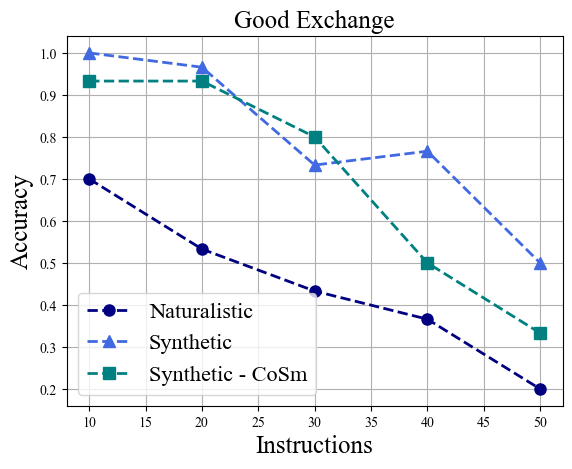

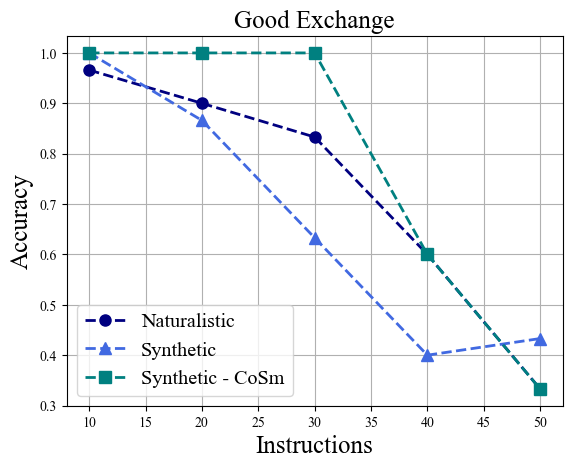

In [20]:

import matplotlib.pyplot as plt
plt.style.use('default')  # reset style
# plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"


x = [10, 20, 30, 40, 50]

# GPT-3.5-Turbo
y_nat = [0.7, 0.533, 0.433, 0.366, 0.2]
y_syn = [1., 0.966, 0.733, 0.766, 0.5]
y_syn_cosm = [0.933, 0.933, 0.8, 0.5, 0.333]

plt.errorbar(x, y_nat, fmt='o', linestyle='dashed', color='navy', linewidth=2, capsize=6, alpha=1, markersize=8, label="naturalistic")
plt.errorbar(x, y_syn, fmt='^', linestyle='dashed', color='royalblue', linewidth=2, capsize=6, alpha=1, markersize=8, label="synthetic")
plt.errorbar(x, y_syn_cosm, fmt='s', linestyle='dashed', color='teal', linewidth=2, capsize=6, alpha=1, markersize=8, label="synthetic")
plt.title("Good Exchange", fontsize=18)
plt.xlabel('Instructions', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend([m for m in ['Naturalistic', 'Synthetic', 'Synthetic - CoSm']], prop={'size': 16}, loc='lower left') #results.keys()])
plt.grid(True)
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
plt.gcf().set_dpi(100)
plt.show()


# GPT-4 (+CoSm)
y_nat = [0.966, 0.9, 0.833, 0.6, 0.333]
y_syn = [1., 0.866, 0.633, 0.4, 0.433]
y_syn_cosm = [1., 1., 1., 0.6, 0.333]

plt.errorbar(x, y_nat, fmt='o', linestyle='dashed', color='navy', linewidth=2, capsize=6, alpha=1, markersize=8, label="naturalistic")
plt.errorbar(x, y_syn, fmt='^', linestyle='dashed', color='royalblue', linewidth=2, capsize=6, alpha=1, markersize=8, label="synthetic")
plt.errorbar(x, y_syn_cosm, fmt='s', linestyle='dashed', color='teal', linewidth=2, capsize=6, alpha=1, markersize=8, label="synthetic")
plt.title("Good Exchange", fontsize=18)
plt.xlabel('Instructions', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend([m for m in ['Naturalistic', 'Synthetic', 'Synthetic - CoSm']], prop={'size': 14.5}, loc='lower left') #results.keys()])
plt.grid(True)
# fig = plt.gcf()
# fig.set_size_inches(6, 3)
plt.show()